# Kinematic Bicycle Model #
## Dynamics ## 
(Note we are using the center of gravity as a reference)
$$ 
x = \begin{bmatrix}
      p_x \\ p_y \\ \theta \\ \delta \\ v
\end{bmatrix}, \quad
u = \begin{bmatrix}
    \alpha \\ \phi
\end{bmatrix}, \quad 
\dot{x} = 
\begin{bmatrix}
    v\cos\theta \\ v\sin\theta \\ 
    \frac{v}{L}\cos\beta\tan\delta \\ \phi \\ \alpha
\end{bmatrix} $$
where
$(p_x, p_y)$ is the position of the center of mass, $\theta$ is the yaw, $\delta$ is the steering angle, $L$ is the distance between the front and rear wheels, $\beta = \tan^{-1}(\ell_r * \delta, L)$ is the , and $\ell_r$ is the length form the center of mass to the rear wheel. 



In [1]:
using ForwardDiff, LinearAlgebra
using Plots, Printf    # For showing results

## Generate Reference Trajectory 

In [93]:
# const x0 = [0.0; 0.0; 0.0; 0.0; 2.0]
const nx = 5   # Number of states 
const nu = 2   # Number of controls 


# THESE MAY NEED TO CHANGE DEPENDING ON TRAJECTORY
const Q = Diagonal([10.0 * ones(2); fill(0.1, 3)]) # Penalize (x, y) error 
const R = Diagonal(fill(1e-1, nu))          # 
const Qf = 10 * Q 

const dt = 0.25
# const N = 101

0.25

In [140]:
function triangleWave(N; freq = (1/10), slope = 0.25 ) 
    """ Makes a triangular wave by using the sign of a sine """
    w = zeros(N)
    signs = zeros(N)
    signs[1] = 1
    for i = 1:N-1
        signs[i + 1] = sign(sin(i * freq))
        w[i + 1] = w[i] + signs[i + 1] * slope
    end
    
    return w, signs
end;

# w, s = triangleWave(101)
# plot(w)

In [141]:
dt

0.5

In [142]:
# Sinusoidal Y
px₀, py₀, θ₀, δ₀, v₀ = 1.0, 0.0, 0.0, 0.0, 2.0
v̄ = 0.5   # Desired velocity
const x0 = [px₀, py₀, θ₀, δ₀, v₀]
# pxs = [px₀ + (i * v̄) for i = 1:N-1 ];           pushfirst!(pxs, px₀)
# pys = [py₀ + (5 * sin(i / 15)) for i = 1:N-1];  pushfirst!(pys, py₀)
# θs  = [0 for i = 1:N-1];                         pushfirst!(θs, θ₀)
# # θs  = [atan(pys[i + 1] - pys[i], pxs[i + 1] - pxs[i]) for i = 1:N-1];                        pushfirst!(θs, θ₀)
# δs  = [0 for i = 1:N-1];                        pushfirst!(δs, δ₀)
# vs  = [v₀ + v̄ for i = 1:N-1];                   pushfirst!(vs, v₀)
# Xref = [ [pxs[i]; pys[i]; θs[i]; δs[i]; vs[i]] for i = 1:N]
Xref = [ [i; 10 * sin(i / 15); 0.0; 0.0; 1.0 / dt ] for i = 1:N]  

Uref = [ 0.01 * randn(2) + [0.0; 0.0] for i = 1:N-1]

# # Make a square wave / sharp turns 
# tWave, tSigns = triangleWave(N; freq = (1/20), slope = 0.1 )
# Xref = [ [i/5; tWave[i]; tSigns[i] * deg2rad(45); 0.0; (0.25 / dt) ] for i = 1:N]


Xrefm = hcat(Xref...)'
display(plot(Xrefm, title = "Reference"))
display(plot(Xrefm[:, 1], Xrefm[:, 2], title = "X/Y"))
# plot(hcat(Uref...)')

LoadError: cannot declare x0 constant; it already has a value

In [3]:
"""
Calculate the continuous time dynamics ẋ = f(x,u), where 
  x is a vector of length nx, u is a vector of length nu.

returns ẋ
"""

function dynamics(x, u; L = 2, Lr = 1.5)
    # Kinematic Bicycle model (referenced to center of mass)
    
    θ, δ, v = x[3:5]   # Yaw, steering angle, velocity
    α, ϕ    = u        # Longitudinal acceleration, steering angle rate 
    
    β = atan(Lr * δ, L)
    s, c = sincos(θ + β)
    ω = v * cos(β) * tan(δ) / L 
    ẋ = v * c 
    ẏ = v * s 
    
    return [ẋ; ẏ; ω; ϕ; α]
end

"""
Integrates the dynamics ODE 1 dt forward, x_{k+1} = rk4(x_k,u_k,dt).

returns x_{k+1}
"""
function rk4(x,u,dt)
    # rk4 for integration
    k1 = dt*dynamics(x, u)
    k2 = dt*dynamics(x + k1/2, u)
    k3 = dt*dynamics(x + k2/2, u)
    k4 = dt*dynamics(x + k3, u)
    return x + (1/6)*(k1 + 2*k2 + 2*k3 + k4)
end

"""
uses forward diff to get the following jacobians of the above discrete dynamics function (rk4):
drk4/dx = A 
drk4/du = B
"""
function dynamics_jacobians(x,u,dt)
    # returns the discrete time dynamics jacobians
    A = ForwardDiff.jacobian(_x -> rk4(_x,u,dt),x)
    B = ForwardDiff.jacobian(_u -> rk4(x,_u,dt),u)
    return A,B
end

dynamics_jacobians

In [4]:
# TASK: Fill out the following methods (10 pts)

function stage_cost(x, u, xref, uref)
    # LQR cost at each knot point (depends on both x and u) (equation provided above)
    J = 0.5 * (x - xref)' * Q * (x - xref) + 0.5 * (u - uref)' * R * (u - uref)
    
    return J
end

function term_cost(x, xref)
    # LQR terminal cost (depends on just x)
    J = 0.5 * (x - xref)' * Qf * (x - xref)
    
    return J
end

function trajectory_cost(X, U, Xref, Uref)
    
    # calculate the cost of a given trajectory 
    J = 0.0
    for i = 1:(N-1)
        J += stage_cost(X[i], U[i], Xref[i], Uref[i])
    end
    
    return J + term_cost(X[N], Xref[N])
end
        
function stage_cost_expansion(x, u, xref, uref)
    # if the stage cost function is J, return the following derivatives:
    # ∇²ₓJ,  ∇ₓJ, ∇²ᵤJ, ∇ᵤJ
    
    Jₓ = Q * (x - xref) 
    Jᵤ = R * (u - uref) 
    
    Jₓₓ = Q 
    Jᵤᵤ = R 
    
    # Note that ∇ₓᵤJ = 0 = ∇ᵤₓJ
    
    return Jₓₓ, Jₓ, Jᵤᵤ, Jᵤ
end

function term_cost_expansion(x, xref )
    # if the terminal cost function is J, return the following derivatives:
    # ∇²ₓJ,  ∇ₓJ

    Jₓ = Qf * (x - xref)
    Jₓₓ = Qf
    
    return Jₓₓ, Jₓ
end

term_cost_expansion (generic function with 1 method)

### Forward & Backward Passes

In [5]:
"""
backward pass for iLQR. Inputs are 
    X - current trajectory              Vector{Vector}
    U - current control                 Vector{Vector}
    Xref - trajectory we want to track  Vector{Vector}
    Uref - control we want to track     Vector{Vector}

We will perform the backwards recursion without any regularization. Store the expected cost 
decrease in ΔJ and return the following 
    d - feedforward control             Vector{Vector}
    K - feedback gain matrices          Vector{Matrix}
    P - cost to go quadratic term       Vector{Matrix}
    ΔJ - expected cost decrease         Float
"""

function backward_pass(X, U, Xref, Uref; ρ = 0.0)

    # allocate all our data
    P = [zeros(nx,nx) for i = 1:N]     # cost to go quadratic term   ∇ₓₓV
    p = [zeros(nx) for i = 1:N]        # cost to go linear term      ∇ₓV
    d = [zeros(nu) for i = 1:N-1]  # feedforward control
    K = [zeros(nu,nx) for i = 1:N-1]   # feedback gain
    ΔJ = 0.0                           # expected cost decrease
    
    # Initial term for P, p 
    P[end], p[end] = term_cost_expansion(X[end], Xref[end])
    
    for i = (N-1):(-1):1
        Jxx, Jx, Juu, Ju = stage_cost_expansion(X[i], U[i], Xref[i], Uref[i])
        A, B = dynamics_jacobians(X[i], U[i], dt)
        
        gx = Jx + A' * p[i + 1] 
        gu = Ju + B' * p[i + 1]
        Gxx = Jxx + A' * P[i + 1] * A 
        Guu = Juu + B' * P[i + 1] * B 
        Gxu = A' * P[i + 1]' * B            
        Gux = B' * P[i + 1] * A
        
        Gxx = Gxx + I * ρ 
        Guu = Guu + I * ρ
        
        d[i] =  Guu \ gu       # d = Gᵤᵤ⁻¹gᵤ 
        K[i] =  Guu \ Gux      # K = Gᵤᵤ⁻¹Gᵤₓ
        
        p[i] = gx  - K[i]' * gu +  K[i]' * Guu * d[i] - Gxu * d[i]
        P[i] = Gxx + K[i]' * Guu * K[i] - Gxu * K[i] - K[i]' * Gux

        ΔJ += gu' * d[i]
    end
    
    return d, K, P, ΔJ    
end

backward_pass (generic function with 1 method)

In [6]:
function forward_pass(X, U, Xref, Uref, K, d, ΔJ; max_linesearch_iters = 20)
    
    J = trajectory_cost(X, U, Xref, Uref)  # Original cost of initial rollout
    
    α = 1.0
    
    Xn, Un, Jn = forward_pass_loop(X, U, Xref, Uref, K, d, α)
    
    num_iters = 0
    while Jn >= (J - 0.01 * α * ΔJ)
        α = 0.5 * α
        Xn, Un, Jn = forward_pass_loop(X, U, Xref, Uref, K, d, α)
        
        num_iters += 1
        if num_iters > max_linesearch_iters
            @warn "Max Linesearch Iterations reached in forward pass!"
            break
        end
    end
    
    return Xn, Un, Jn, α
end


function forward_pass_loop(X, U, Xref, Uref, K, d, α)
    N = size(X, 1)
    
    Xn, Un = deepcopy(X), deepcopy(U)
    
    for i = 1:(N - 1)
        Un[i] = U[i] - α * d[i] - K[i] * (Xn[i] - X[i])  
        Xn[i + 1] = rk4(Xn[i], Un[i], dt) 
    end
    Jn = trajectory_cost(Xn, Un, Xref, Uref)
    
    return Xn, Un, Jn 
end

forward_pass_loop (generic function with 1 method)

In [59]:
"""
iLQR will combine the backward and forward passes for the complete iLQR algorithm. We will classify 
convergence as when the maximum norm of each feedforward control input in d is below atol. (this is given)

inputs:
    x0 - initial condition Vector
    U - initial control history Vector{Vector}
    Xref - reference trajectory we are trying to track Vector{Vector}
    Uref - reference controls we are trying to track Vector{Vector}

outputs:
    X - optimal trajectory Vector{Vector}
    U - optimal control trajectory Vector{Vector}
    K - feedback gain matrices Vector{Matrix}
    P - cost to go hessians Vector{Matrix}
    iter - iterations it took to converge Int
"""
function iLQR(x0, U, Xref, Uref; atol = 1e-4, max_iters = 100, verbose = true)
    
    # initial logging stuff 

    if verbose
        @printf "iter     J\t\t           ΔJ\t\t        |d|\t         α\n"
        @printf "--------------------------------------------------------\n"
    end
    
    P = [zeros(nx,nx) for i = 1:N]       # cost to go quadratic term   ∇ₓₓV
    d = [zeros(nu)    for i = 1:N - 1]   # feedforward control
    K = [zeros(nu,nx) for i = 1:N - 1]   # feedback gain
    X = [zeros(nx)    for i = 1:N]
    iter = -1 

    # Generate inital X using initial U 
    X[1] = copy(x0)
    for i = 1:N - 1  
        X[i + 1] = rk4(X[i], U[i], dt) 
    end
     
    for i = 1:max_iters
        dn, Kn, Pn, ΔJ = backward_pass(X, U, Xref, Uref)
        d .= dn 
        K .= Kn 
        P .= Pn
    
        # Check for termination 
        dMax = maximum(norm.(d))  #maximum([maximum(abs.(d[j])) for j = 1:size(d, 1)])
        if dMax < atol
            println("$i  \t$ΔJ  \t$dMax  ")
            iter = i
            
#             break
            return X, U, Kn, Pn, iter

        end
        
        # Forward pass
        X, U, Jn, α = forward_pass(X, U, Xref, Uref, K, d, ΔJ)
    
        
        if verbose
            println("$i  \t$(round(Jn, digits = 5))  \t$(round(ΔJ, digits = 5))  \t$(round(dMax, digits = 5))  \t$α")
        end
        
        
        if iter == max_iters
            @warn "Max iters hit in iLQR!"
        end
    end

    return X, U, K, P, iter

end
        

iLQR

In [96]:
# RUN 
x0 = Xref[1]
X, U, K, _, _ = iLQR(x0, Uref, Xref, Uref);

iter     J		           ΔJ		        |d|	         α
--------------------------------------------------------
1  	1.00765523432e6  	3.73870859286e6  	33.38047  	1.0
2  	774129.88364  	1.95552825899e6  	36.51681  	0.125
3  	650666.83696  	1.48550692052e6  	31.40453  	0.125
4  	593176.33035  	1.24162190331e6  	37.65566  	0.0625
5  	388532.56889  	1.10075949234e6  	43.24765  	0.25
6  	354949.44289  	687042.22358  	19.89243  	0.0625
7  	336923.79057  	610970.32785  	19.17583  	0.03125
8  	273615.74848  	562115.25884  	19.1048  	0.125
9  	239644.60933  	475257.39934  	15.91671  	0.125
10  	232785.71896  	426271.98989  	14.54275  	0.015625
11  	225859.2618  	411409.52822  	14.32344  	0.015625
12  	218449.85963  	395977.33019  	14.09698  	0.015625
13  	207073.75908  	378132.57247  	13.86679  	0.03125
14  	200324.68192  	357939.47588  	13.39058  	0.015625
15  	181852.86022  	342563.93696  	13.14985  	0.0625
16  	148662.17024  	309289.71286  	12.05258  	0.125
17  	146324.30532  	236993.10807  	8.8

┌ Warning: Max Linesearch Iterations reached in forward pass!
└ @ Main In[6]:16


63  	43948.41503  	53141.69569  	9.12572  	0.015625
64  	43924.61053  	17054.22199  	4.38604  	0.015625
65  	43912.06378  	57820.14674  	11.79256  	0.00390625
66  	43893.59258  	39508.64963  	8.2531  	0.015625
67  	43883.37929  	16637.44613  	15.94243  	0.015625
68  	43883.3831  	372240.19598  	345.85072  	4.76837158203125e-7
69  	43738.41321  	150402.57342  	750.07366  	0.015625
70  	43717.59992  	17834.39959  	1.98978  	0.015625
71  	43684.53837  	23354.02502  	3.32736  	0.015625
72  	43678.41152  	35826.51103  	4.48387  	0.015625
73  	43670.61433  	35910.15835  	13.84658  	0.00390625
74  	43523.05123  	14422.13502  	5.75835  	0.125


┌ Warning: Max Linesearch Iterations reached in forward pass!
└ @ Main In[6]:16


75  	43519.24447  	13727.94588  	1.51887  	0.015625
76  	43459.58955  	35414.92278  	4.93336  	0.015625
77  	43449.66923  	30865.56008  	11.14867  	0.00390625
78  	43447.60647  	24401.55845  	2.84354  	0.00390625
79  	43445.48768  	16334.15394  	5.86845  	0.0078125
80  	43393.93089  	11501.14311  	7.42863  	0.125
81  	43386.52653  	8000.21594  	6.35669  	0.001953125
82  	43383.71509  	10369.26001  	2.18102  	0.00390625
83  	43383.4607  	9445.88707  	20.59876  	0.00048828125
84  	43383.43545  	9225.31428  	5.7363  	0.000244140625
85  	43383.42056  	9207.01569  	5.75925  	0.0001220703125
86  	43380.63291  	6344.61885  	1.80827  	0.001953125
87  	43380.63455  	29567.64034  	4.93017  	4.76837158203125e-7
88  	43380.63475  	10041.00399  	5.0524  	4.76837158203125e-7
89  	43346.82848  	70881.25186  	191.02619  	0.0078125
90  	43346.83165  	327346.91544  	4.13037  	4.76837158203125e-7
91  	43340.82149  	17211.24084  	2.01308  	0.00390625


┌ Warning: Max Linesearch Iterations reached in forward pass!
└ @ Main In[6]:16
┌ Warning: Max Linesearch Iterations reached in forward pass!
└ @ Main In[6]:16
┌ Warning: Max Linesearch Iterations reached in forward pass!
└ @ Main In[6]:16


92  	43340.72005  	15575.46488  	1.83309  	0.00048828125
93  	43334.8389  	7925.51489  	1.64826  	0.00390625
94  	43334.49213  	11065.16641  	3.09684  	0.0009765625
95  	43283.06223  	6997.16432  	1.62423  	0.03125
96  	43282.72046  	10123.70038  	3.26173  	0.000244140625
97  	43282.45677  	10036.50567  	3.48975  	0.000244140625
98  	43282.45692  	38336.80211  	11.43009  	4.76837158203125e-7
99  	43282.36981  	7816.40147  	2.70854  	0.00048828125
100  	43282.24884  	9077.07391  	4.38356  	0.000244140625


┌ Warning: Max Linesearch Iterations reached in forward pass!
└ @ Main In[6]:16


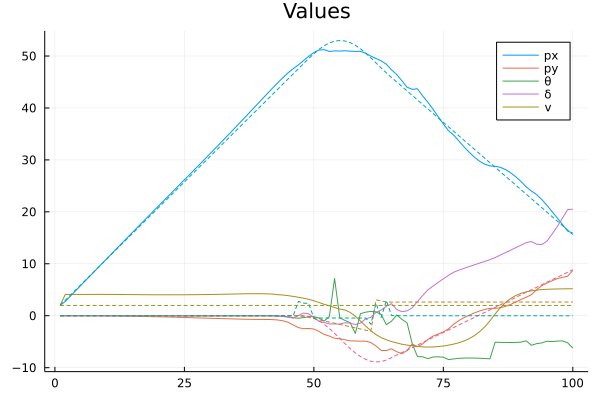

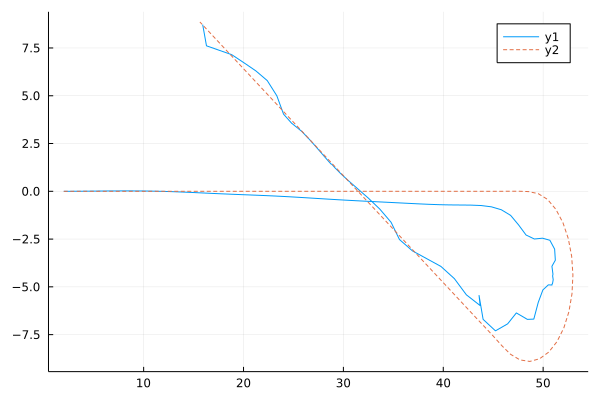

In [97]:
Xrefm = hcat(Xref...)'
a = plot(hcat(X...)', label = ["px" "py" "θ" "δ" "v"])
a = plot!(Xrefm, ls = :dash, label = false, title = "Values")
display(a)


Xm = hcat(X...)'
b = plot(Xm[:, 1], Xm[:, 2])
b = plot!(Xrefm[:, 1], Xrefm[:, 2], ls = :dash)
display(b)

## MESHCAT Stuff

In [68]:
# ADD IN MESHCAT WITH COOL SHADOW FOR REAL VS REF
using RobotZoo
using StaticArrays
include("car.jl")

  Activating environment at `~/Classes/16-745_OCRL/Project/Project.toml`


plot_region!

In [98]:
model = RobotZoo.BicycleModel()
vis = initialize_visualizer(model)
render(vis)

┌ Info: MeshCat server started. You can open the visualizer by visiting the following URL in your browser:
│ http://127.0.0.1:8704
└ @ MeshCat /home/benjj/.julia/packages/MeshCat/GlCMx/src/visualizer.jl:73


MeshCat.DisplayedVisualizer(MeshCat.CoreVisualizer(MeshCat.SceneTrees.SceneNode(nothing, nothing, Dict{String, Vector{UInt8}}(), nothing, Dict{String, MeshCat.SceneTrees.SceneNode}("meshcat" => MeshCat.SceneTrees.SceneNode(nothing, nothing, Dict{String, Vector{UInt8}}(), nothing, Dict{String, MeshCat.SceneTrees.SceneNode}("robot" => MeshCat.SceneTrees.SceneNode(nothing, nothing, Dict{String, Vector{UInt8}}(), nothing, Dict{String, MeshCat.SceneTrees.SceneNode}("geom" => MeshCat.SceneTrees.SceneNode(UInt8[0x83, 0xa6, 0x6f, 0x62, 0x6a, 0x65, 0x63, 0x74, 0x84, 0xaa  …  0x72, 0x6f, 0x62, 0x6f, 0x74, 0x2f, 0x67, 0x65, 0x6f, 0x6d], UInt8[0x83, 0xa6, 0x6d, 0x61, 0x74, 0x72, 0x69, 0x78, 0xc7, 0x40  …  0x72, 0x6f, 0x62, 0x6f, 0x74, 0x2f, 0x67, 0x65, 0x6f, 0x6d], Dict{String, Vector{UInt8}}(), nothing, Dict{String, MeshCat.SceneTrees.SceneNode}("chassis" => MeshCat.SceneTrees.SceneNode(nothing, UInt8[0x83, 0xa6, 0x6d, 0x61, 0x74, 0x72, 0x69, 0x78, 0xc7, 0x40  …  0x6f, 0x6d, 0x2f, 0x63, 0x68, 0x61, 0x73, 0x73, 0x69, 0x73], Dict{String, Vector{UInt8}}(), nothing, Dict{String, MeshCat.SceneTrees.SceneNode}("body" => MeshCat.SceneTrees.SceneNode(UInt8[0x83, 0xa6, 0x6f, 0x62, 0x6a, 0x65, 0x63, 0x74, 0x84, 0xaa  …  0x61, 0x73, 0x73, 0x69, 0x73, 0x2f, 0x62, 0x6f, 0x64, 0x79], nothing, Dict{String, Vector{UInt8}}(), nothing, Dict{String, MeshCat.SceneTrees.SceneNode}()), "wheel" => MeshCat.SceneTrees.SceneNode(UInt8[0x83, 0xa6, 0x6f, 0x62, 0x6a, 0x65, 0x63, 0x74, 0x84, 0xaa  …  0x73, 0x73, 0x69, 0x73, 0x2f, 0x77, 0x68, 0x65, 0x65, 0x6c], nothing, Dict{String, Vector{UInt8}}(), nothing, Dict{String, MeshCat.SceneTrees.SceneNode}()))), "front" => MeshCat.SceneTrees.SceneNode(nothing, UInt8[0x83, 0xa6, 0x6d, 0x61, 0x74, 0x72, 0x69, 0x78, 0xc7, 0x40  …  0x67, 0x65, 0x6f, 0x6d, 0x2f, 0x66, 0x72, 0x6f, 0x6e, 0x74], Dict{String, Vector{UInt8}}(), nothing, Dict{String, MeshCat.SceneTrees.SceneNode}("wheel" => MeshCat.SceneTrees.SceneNode(UInt8[0x83, 0xa6, 0x6f, 0x62, 0x6a, 0x65, 0x63, 0x74, 0x84, 0xaa  …  0x72, 0x6f, 0x6e, 0x74, 0x2f, 0x77, 0x68, 0x65, 0x65, 0x6c], nothing, Dict{String, Vector{UInt8}}(), nothing, Dict{String, MeshCat.SceneTrees.SceneNode}()))))))))))), Set{Any}(), ip"127.0.0.1", 8704))

In [100]:
Xref_static = [SVector{nx, Float64}(Xref[i]) for i = 1:N]
X_static    = [SVector{nx, Float64}(X[i]) for i = 1:N]

visualize!(vis, model, N * dt / 4.0, X_static)

In [57]:
# using Colors
# # using TrajOptPlots
# visualize!(vis, model, N * dt / 4, X_static, Xref_static, colors=[colorant"blue", RGBA(0,0,1,0.5)])

In [8]:
function cheating(θ⁺, θ⁻, v, dt; L = 2, Lr = 1.5)
    diff = 1000.0
    bestδ = 0.0
    for δ = -(π-0.2):0.01:(π - 0.2)
        d = abs((L * (θ⁺ - θ⁻)/(v * dt)) - cos(atan(Lr * δ / L)) * tan(δ))
        
        if d < diff 
            diff = d 
            bestδ = δ
        end
    end
    
    return bestδ
end

cheating (generic function with 1 method)

### Read in trajectory

In [94]:
using Interpolations
function createRef(file::String, dt; verbose = false, L = 2, Lr = 1.5)
    
    # Convert from a .txt to a matrix 
    pxs, pys = getPositions(file)
    pxInt = interpolate(pxs, BSpline(Cubic(Line(OnGrid()))))
    pyInt = interpolate(pys, BSpline(Cubic(Line(OnGrid()))))

    upSampleRate = 2
    pxs = pxInt(range(1, 50, length = 50 * upSampleRate)) .- 100.0
    pys = pyInt(range(1, 50, length = 50 * upSampleRate)) .- 100.0
    
    dtn = dt * upSampleRate  # Don't need to go as fast, now...
    N = length(pxs)
    
    # Make ref θs by using consecutive pairs of points
    θs = [ atan(pys[i + 1] - pys[i], pxs[i + 1] - pxs[i]) for i = 1:N - 1]
    push!(θs, θs[end])  # Just add the last angle again to match length 

    # Make ref vs by using the amount of change occuring per time step
    vs = [ sqrt( (pys[i + 1] - pys[i])^2 + (pxs[i + 1] - pxs[i])^2) / (dtn)  for i = 1:N - 1 ]
    push!(vs, vs[end])    
    
    δs = [cheating(θs[i + 1], θs[i], vs[i], dtn) for i = 1:N - 1]
    push!(δs, δs[end])
    
    ϕs = [ (δs[i + 1] - δs[i - 1]) / (2 * dtn) for i = 2:N - 1]
    ϕs = [0; ϕs; ϕs[end]]
#     push!(ϕs, ϕs[end])

    αs = [ (vs[i + 1] - vs[i - 1]) / (2 * dtn) for i = 2:N - 1]
    αs = [0.0; αs; αs[end]]
    
#     θs = zeros(N)
#     vs = zeros(N)
#     δs = zeros(N)   # Solving for this from Δθ would be a nightmare
#     ϕs = 0.1 * randn(N)
#     αs = 0.1 * randn(N)
    

    Xref = [ [pxs[i], pys[i], θs[i], δs[i], vs[i]] for i = 1:N]
    Uref = [ [αs[i], ϕs[i]] for i = 1:N-1]
    
    return Xref, Uref
end


function getPositions(file::String)
    pos = []
    open(file) do f

        # read till end of file

        while ! eof(f) 

            s = readline(f)  # Read in a row of data

            s = parse.(Float64, split(s, " "))  # Separate by spaces, and then convert to a float

            push!(pos, s)  # Add to the vector
        end
    end

    pos = hcat(pos...)'
    
    return pos[:, 1], pos[:, 2]
end

using Plots
file = "../logs/curvy_traj.txt" #"../logs/trajectory_good4.txt"
Xref, Uref = createRef(file, dt);
N = size(Xref, 1)

100

In [48]:
# Xrefm = hcat(Xref...)'
# display(plot(Xrefm[:, 1], Xrefm[:, 2]))
# display(plot(Xrefm[:, 3:5], label = ["θ" "δ" "v"]))
# # display(plot(Xrefm[:, 5]))

# Urefm = hcat(Uref...)'
# display(plot(Urefm))

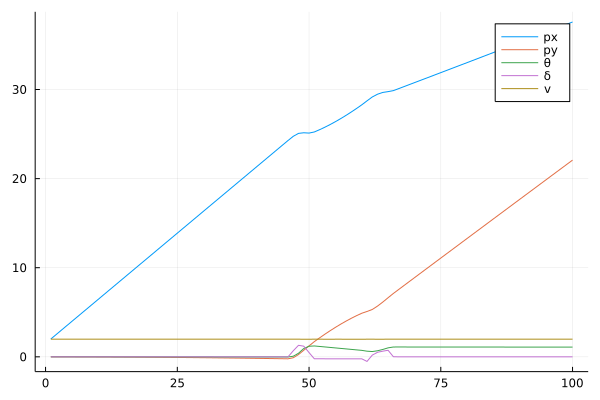

In [95]:
function wrap(X)
    x, y, θ, δ, v = X
    # θ 
    while (θ > pi)
        θ -= pi
    end
    
    while (θ < -pi)
        θ += pi
    end
    
    # δ
    while (δ > pi)
        δ -= pi
    end
    
    while (δ < -pi)
        δ += pi
    end
    
    return [x, y, θ, δ, v]
    
end

function rollout(x0, Uref)
    X = [x0 for i = 1:size(Uref, 1) + 1]
    X[1] = x0 
    
    for i = 1:size(X, 1) - 1
        Xn = rk4(X[i], Uref[i], dt) 
        X[i + 1] = wrap(Xn)
    end
    return X
end
Xr = rollout(Xref[1], Uref)
Xrm = hcat(Xr...)'
Xrefm = hcat(Xref...)'

# plot(Xrm[:, 1], Xrm[:, 2])
display(plot(Xrm, label = ["px" "py" "θ" "δ" "v"]))
# display(plot(Xrm[:, 1], Xrm[:, 2], title = "Position", xlabel = "px", ylabel = "py"))
# plot(Xrm[:, 3])
# display(scatter!(Xrefm[:, 3], ls = :dash))
# plot(Xrm[:, 5])